# Benchmarking feature selection algorithms in the molecular property prediction space: Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

*Alejandro Corrochano's contribution to the final project.* 

In [1]:
# Datasets
from tdc.single_pred import ADME

# Additional functions in a separate ipynb file
from ipynb.fs.full.AZ_additional_functions import *

# General use 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

#import shap
#Save and load models
import joblib

# RDkit
from rdkit import Chem
from rdkit import RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Standardizing
from molvs import standardize_smiles

In [2]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
data_overview(df, split_LIPO)

Total number of molecules: 4200
Train set: 2940 - 70.0%
Validation set: 420 - 10.0%
Test set: 840 - 20.0%


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


In [4]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified: {}'.format(len(frag_compounds)))

Number of compounds modified: 1


In [5]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
New number of compounds: 4200 (0)


### Descriptors
Contain numerical information regarding the molecule 

In [6]:
descList = [i for i,j in Descriptors.descList]
#Molecular descriptor calculator
calculator = MolecularDescriptorCalculator(descList)
print('Calculator initialized. Total number of descriptors:', len(descList))

Calculator initialized. Total number of descriptors: 208


In [7]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (4200, 211)


In [8]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.10


### Generate splits, remove NaNs, and normalization

#### Train, validation, and test sets for both Descriptors and fingerprints

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(df, split_LIPO)

Data has been split


#### Remove NaNs values

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test)

Removed the following rows in the train set: Int64Index([1561], dtype='int64')


#### Data normalization required in linear models

In [11]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


## Building our baseline models

In order to get some initial results, we will now construct a few baseline models where all the features are included without any preprocessing.

We now compare the metrics obtained for each of the following models:
- Linear regression (**LR**)
- Random forest regressor (**RFR**)
- Decision tree regressor (**DTR**)
- Support vector machine (**SVM**)
- Multi-layer Perceptron regressor (**MLP**)
- XG Boost regressor (**XGB**)

#### Descriptors

LR | R2: 0.599, MAE: 0.594, MSE: 0.597 | Training time: 0.1
RFR | R2: 0.645, MAE: 0.547, MSE: 0.529 | Training time: 21.0
DTR | R2: 0.262, MAE: 0.776, MSE: 1.099 | Training time: 0.3
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463 | Training time: 1.2
MLPR | R2: 0.652, MAE: 0.514, MSE: 0.517 | Training time: 4.8
XGBR | R2: 0.643, MAE: 0.545, MSE: 0.531 | Training time: 2.8


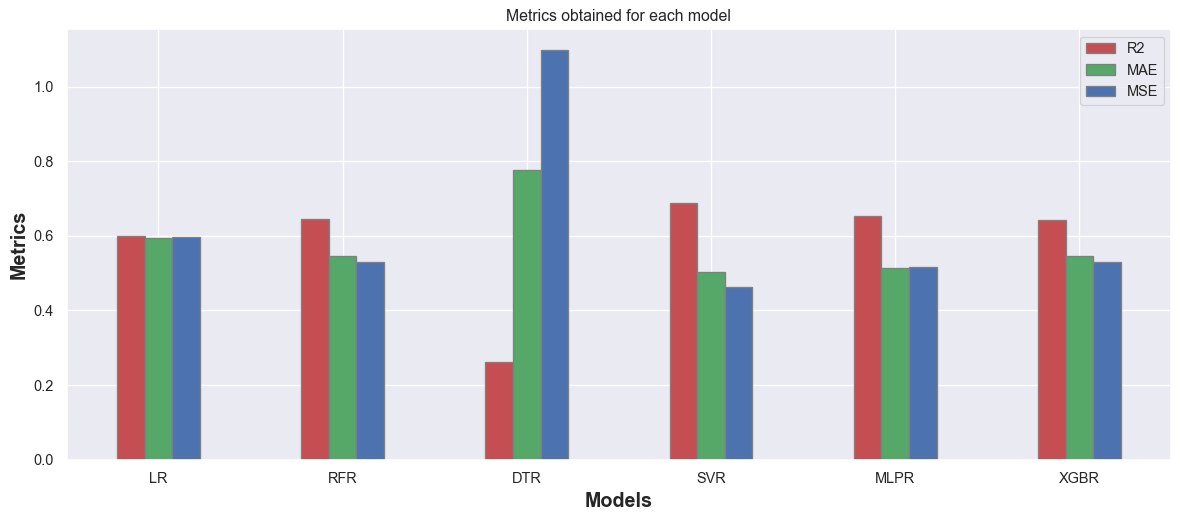

In [12]:
models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, False, X_train_norm, X_val_norm)

## 1 - Improving the model: Feature Selection - MRMR

Short description about mrmr 

In [13]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16it/s]


LR | R2: -0.006, MAE: 0.997, MSE: 1.497 | Training time: 0.0
RFR | R2: -0.055, MAE: 0.956, MSE: 1.571 | Training time: 0.7
DTR | R2: -0.387, MAE: 1.077, MSE: 2.064 | Training time: 0.0
SVR | R2: -0.035, MAE: 0.994, MSE: 1.541 | Training time: 0.4
MLPR | R2: -0.006, MAE: 0.994, MSE: 1.497 | Training time: 0.9
XGBR | R2: 0.105, MAE: 0.916, MSE: 1.333 | Training time: 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.37it/s]


LR | R2: -0.005, MAE: 0.996, MSE: 1.496 | Training time: 0.0
RFR | R2: -0.049, MAE: 0.952, MSE: 1.562 | Training time: 0.6
DTR | R2: -0.393, MAE: 1.081, MSE: 2.073 | Training time: 0.0
SVR | R2: -0.032, MAE: 0.991, MSE: 1.536 | Training time: 0.4
MLPR | R2: -0.009, MAE: 0.999, MSE: 1.502 | Training time: 0.6
XGBR | R2: 0.080, MAE: 0.931, MSE: 1.370 | Training time: 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.11it/s]


LR | R2: 0.114, MAE: 0.937, MSE: 1.319 | Training time: 0.0
RFR | R2: 0.119, MAE: 0.867, MSE: 1.312 | Training time: 0.7
DTR | R2: -0.184, MAE: 0.994, MSE: 1.762 | Training time: 0.0
SVR | R2: 0.090, MAE: 0.930, MSE: 1.355 | Training time: 0.4
MLPR | R2: 0.086, MAE: 0.946, MSE: 1.360 | Training time: 1.2
XGBR | R2: 0.223, MAE: 0.844, MSE: 1.157 | Training time: 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.70it/s]


LR | R2: 0.120, MAE: 0.931, MSE: 1.310 | Training time: 0.0
RFR | R2: 0.133, MAE: 0.862, MSE: 1.291 | Training time: 1.0
DTR | R2: -0.222, MAE: 0.995, MSE: 1.819 | Training time: 0.0
SVR | R2: 0.090, MAE: 0.929, MSE: 1.355 | Training time: 0.6
MLPR | R2: 0.104, MAE: 0.941, MSE: 1.333 | Training time: 1.5
XGBR | R2: 0.246, MAE: 0.833, MSE: 1.123 | Training time: 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.92it/s]


LR | R2: 0.359, MAE: 0.790, MSE: 0.955 | Training time: 0.0
RFR | R2: 0.403, MAE: 0.723, MSE: 0.888 | Training time: 1.1
DTR | R2: 0.030, MAE: 0.881, MSE: 1.444 | Training time: 0.0
SVR | R2: 0.362, MAE: 0.765, MSE: 0.950 | Training time: 0.6
MLPR | R2: 0.386, MAE: 0.754, MSE: 0.914 | Training time: 3.3
XGBR | R2: 0.422, MAE: 0.727, MSE: 0.860 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.48it/s]


LR | R2: 0.384, MAE: 0.767, MSE: 0.917 | Training time: 0.0
RFR | R2: 0.466, MAE: 0.688, MSE: 0.795 | Training time: 1.2
DTR | R2: 0.132, MAE: 0.824, MSE: 1.292 | Training time: 0.0
SVR | R2: 0.381, MAE: 0.741, MSE: 0.922 | Training time: 0.7
MLPR | R2: 0.400, MAE: 0.731, MSE: 0.892 | Training time: 3.2
XGBR | R2: 0.446, MAE: 0.716, MSE: 0.825 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.86it/s]


LR | R2: 0.389, MAE: 0.767, MSE: 0.910 | Training time: 0.0
RFR | R2: 0.474, MAE: 0.687, MSE: 0.783 | Training time: 1.3
DTR | R2: 0.089, MAE: 0.863, MSE: 1.357 | Training time: 0.0
SVR | R2: 0.403, MAE: 0.731, MSE: 0.889 | Training time: 0.6
MLPR | R2: 0.401, MAE: 0.729, MSE: 0.891 | Training time: 4.9
XGBR | R2: 0.489, MAE: 0.679, MSE: 0.761 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 16.11it/s]


LR | R2: 0.399, MAE: 0.759, MSE: 0.895 | Training time: 0.0
RFR | R2: 0.485, MAE: 0.673, MSE: 0.767 | Training time: 1.5
DTR | R2: 0.158, MAE: 0.831, MSE: 1.254 | Training time: 0.0
SVR | R2: 0.421, MAE: 0.715, MSE: 0.862 | Training time: 0.7
MLPR | R2: 0.444, MAE: 0.705, MSE: 0.828 | Training time: 2.3
XGBR | R2: 0.472, MAE: 0.691, MSE: 0.786 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.85it/s]


LR | R2: 0.408, MAE: 0.754, MSE: 0.881 | Training time: 0.0
RFR | R2: 0.468, MAE: 0.678, MSE: 0.792 | Training time: 1.7
DTR | R2: 0.046, MAE: 0.882, MSE: 1.420 | Training time: 0.0
SVR | R2: 0.440, MAE: 0.697, MSE: 0.834 | Training time: 0.6
MLPR | R2: 0.402, MAE: 0.711, MSE: 0.890 | Training time: 6.3
XGBR | R2: 0.492, MAE: 0.674, MSE: 0.756 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 17.04it/s]


LR | R2: 0.410, MAE: 0.747, MSE: 0.879 | Training time: 0.0
RFR | R2: 0.522, MAE: 0.646, MSE: 0.712 | Training time: 2.0
DTR | R2: 0.081, MAE: 0.875, MSE: 1.368 | Training time: 0.0
SVR | R2: 0.456, MAE: 0.672, MSE: 0.810 | Training time: 0.7
MLPR | R2: 0.372, MAE: 0.701, MSE: 0.935 | Training time: 4.7
XGBR | R2: 0.520, MAE: 0.653, MSE: 0.715 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.97it/s]


LR | R2: 0.429, MAE: 0.732, MSE: 0.850 | Training time: 0.0
RFR | R2: 0.552, MAE: 0.624, MSE: 0.667 | Training time: 2.3
DTR | R2: 0.105, MAE: 0.854, MSE: 1.331 | Training time: 0.0
SVR | R2: 0.490, MAE: 0.645, MSE: 0.760 | Training time: 0.6
MLPR | R2: 0.398, MAE: 0.698, MSE: 0.896 | Training time: 7.7
XGBR | R2: 0.579, MAE: 0.602, MSE: 0.626 | Training time: 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.44it/s]


LR | R2: 0.444, MAE: 0.724, MSE: 0.828 | Training time: 0.0
RFR | R2: 0.560, MAE: 0.618, MSE: 0.655 | Training time: 2.5
DTR | R2: 0.223, MAE: 0.787, MSE: 1.156 | Training time: 0.0
SVR | R2: 0.509, MAE: 0.633, MSE: 0.731 | Training time: 0.6
MLPR | R2: 0.438, MAE: 0.675, MSE: 0.837 | Training time: 7.0
XGBR | R2: 0.596, MAE: 0.592, MSE: 0.601 | Training time: 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:04<00:00, 17.22it/s]


LR | R2: 0.472, MAE: 0.703, MSE: 0.786 | Training time: 0.0
RFR | R2: 0.574, MAE: 0.608, MSE: 0.634 | Training time: 3.1
DTR | R2: 0.248, MAE: 0.781, MSE: 1.119 | Training time: 0.0
SVR | R2: 0.566, MAE: 0.600, MSE: 0.647 | Training time: 0.6
MLPR | R2: 0.463, MAE: 0.642, MSE: 0.800 | Training time: 5.4
XGBR | R2: 0.610, MAE: 0.573, MSE: 0.581 | Training time: 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 17.75it/s]


LR | R2: 0.481, MAE: 0.691, MSE: 0.773 | Training time: 0.0
RFR | R2: 0.600, MAE: 0.585, MSE: 0.596 | Training time: 3.3
DTR | R2: 0.192, MAE: 0.812, MSE: 1.203 | Training time: 0.1
SVR | R2: 0.585, MAE: 0.584, MSE: 0.618 | Training time: 0.7
MLPR | R2: 0.580, MAE: 0.567, MSE: 0.625 | Training time: 4.4
XGBR | R2: 0.635, MAE: 0.554, MSE: 0.543 | Training time: 0.6


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 18.22it/s]


LR | R2: 0.488, MAE: 0.689, MSE: 0.761 | Training time: 0.0
RFR | R2: 0.613, MAE: 0.578, MSE: 0.576 | Training time: 3.8
DTR | R2: 0.264, MAE: 0.789, MSE: 1.095 | Training time: 0.1
SVR | R2: 0.595, MAE: 0.578, MSE: 0.603 | Training time: 0.6
MLPR | R2: 0.537, MAE: 0.601, MSE: 0.690 | Training time: 3.5
XGBR | R2: 0.653, MAE: 0.544, MSE: 0.516 | Training time: 0.6


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:04<00:00, 18.20it/s]


LR | R2: 0.498, MAE: 0.682, MSE: 0.748 | Training time: 0.0
RFR | R2: 0.615, MAE: 0.580, MSE: 0.573 | Training time: 4.2
DTR | R2: 0.176, MAE: 0.814, MSE: 1.226 | Training time: 0.1
SVR | R2: 0.611, MAE: 0.568, MSE: 0.579 | Training time: 0.7
MLPR | R2: 0.555, MAE: 0.589, MSE: 0.662 | Training time: 4.8
XGBR | R2: 0.642, MAE: 0.547, MSE: 0.534 | Training time: 0.6


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 17.52it/s]


LR | R2: 0.512, MAE: 0.673, MSE: 0.727 | Training time: 0.0
RFR | R2: 0.612, MAE: 0.577, MSE: 0.578 | Training time: 4.5
DTR | R2: 0.311, MAE: 0.747, MSE: 1.026 | Training time: 0.1
SVR | R2: 0.630, MAE: 0.555, MSE: 0.551 | Training time: 0.7
MLPR | R2: 0.566, MAE: 0.591, MSE: 0.646 | Training time: 4.2
XGBR | R2: 0.643, MAE: 0.549, MSE: 0.531 | Training time: 0.6


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 18.90it/s]


LR | R2: 0.523, MAE: 0.662, MSE: 0.709 | Training time: 0.0
RFR | R2: 0.623, MAE: 0.565, MSE: 0.561 | Training time: 5.3
DTR | R2: 0.290, MAE: 0.776, MSE: 1.057 | Training time: 0.1
SVR | R2: 0.639, MAE: 0.545, MSE: 0.537 | Training time: 0.9
MLPR | R2: 0.624, MAE: 0.554, MSE: 0.559 | Training time: 4.5
XGBR | R2: 0.640, MAE: 0.544, MSE: 0.536 | Training time: 0.7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.52it/s]


LR | R2: 0.543, MAE: 0.641, MSE: 0.680 | Training time: 0.0
RFR | R2: 0.634, MAE: 0.554, MSE: 0.545 | Training time: 6.3
DTR | R2: 0.294, MAE: 0.754, MSE: 1.051 | Training time: 0.1
SVR | R2: 0.655, MAE: 0.529, MSE: 0.514 | Training time: 0.7
MLPR | R2: 0.624, MAE: 0.539, MSE: 0.559 | Training time: 4.3
XGBR | R2: 0.656, MAE: 0.520, MSE: 0.513 | Training time: 0.8


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:05<00:00, 19.21it/s]


LR | R2: 0.564, MAE: 0.629, MSE: 0.649 | Training time: 0.0
RFR | R2: 0.629, MAE: 0.555, MSE: 0.553 | Training time: 6.7
DTR | R2: 0.311, MAE: 0.753, MSE: 1.026 | Training time: 0.1
SVR | R2: 0.663, MAE: 0.524, MSE: 0.501 | Training time: 0.8
MLPR | R2: 0.619, MAE: 0.533, MSE: 0.567 | Training time: 3.7
XGBR | R2: 0.667, MAE: 0.521, MSE: 0.496 | Training time: 0.9


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 16.85it/s]


LR | R2: 0.566, MAE: 0.625, MSE: 0.646 | Training time: 0.0
RFR | R2: 0.633, MAE: 0.551, MSE: 0.546 | Training time: 7.7
DTR | R2: 0.180, MAE: 0.827, MSE: 1.221 | Training time: 0.1
SVR | R2: 0.666, MAE: 0.521, MSE: 0.497 | Training time: 0.8
MLPR | R2: 0.612, MAE: 0.535, MSE: 0.578 | Training time: 5.3
XGBR | R2: 0.635, MAE: 0.542, MSE: 0.543 | Training time: 0.8


100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:06<00:00, 17.97it/s]


LR | R2: 0.571, MAE: 0.620, MSE: 0.639 | Training time: 0.0
RFR | R2: 0.636, MAE: 0.551, MSE: 0.542 | Training time: 7.8
DTR | R2: 0.236, MAE: 0.791, MSE: 1.137 | Training time: 0.1
SVR | R2: 0.672, MAE: 0.518, MSE: 0.488 | Training time: 0.7
MLPR | R2: 0.547, MAE: 0.585, MSE: 0.674 | Training time: 3.2
XGBR | R2: 0.692, MAE: 0.501, MSE: 0.458 | Training time: 0.8


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.23it/s]


LR | R2: 0.566, MAE: 0.625, MSE: 0.646 | Training time: 0.1
RFR | R2: 0.633, MAE: 0.550, MSE: 0.546 | Training time: 9.0
DTR | R2: 0.222, MAE: 0.783, MSE: 1.157 | Training time: 0.1
SVR | R2: 0.673, MAE: 0.517, MSE: 0.486 | Training time: 0.7
MLPR | R2: 0.624, MAE: 0.538, MSE: 0.560 | Training time: 3.8
XGBR | R2: 0.654, MAE: 0.534, MSE: 0.515 | Training time: 0.8


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 20.35it/s]


LR | R2: 0.562, MAE: 0.628, MSE: 0.652 | Training time: 0.1
RFR | R2: 0.637, MAE: 0.554, MSE: 0.541 | Training time: 9.6
DTR | R2: 0.195, MAE: 0.809, MSE: 1.198 | Training time: 0.1
SVR | R2: 0.670, MAE: 0.522, MSE: 0.492 | Training time: 1.0
MLPR | R2: 0.614, MAE: 0.544, MSE: 0.574 | Training time: 5.4
XGBR | R2: 0.659, MAE: 0.536, MSE: 0.508 | Training time: 0.9


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:06<00:00, 18.90it/s]


LR | R2: 0.570, MAE: 0.622, MSE: 0.641 | Training time: 0.1
RFR | R2: 0.630, MAE: 0.557, MSE: 0.550 | Training time: 10.5
DTR | R2: 0.240, MAE: 0.780, MSE: 1.131 | Training time: 0.2
SVR | R2: 0.670, MAE: 0.522, MSE: 0.491 | Training time: 0.9
MLPR | R2: 0.642, MAE: 0.538, MSE: 0.533 | Training time: 5.1
XGBR | R2: 0.665, MAE: 0.526, MSE: 0.498 | Training time: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:06<00:00, 20.36it/s]


LR | R2: 0.572, MAE: 0.613, MSE: 0.637 | Training time: 0.1
RFR | R2: 0.643, MAE: 0.550, MSE: 0.532 | Training time: 10.2
DTR | R2: 0.217, MAE: 0.788, MSE: 1.166 | Training time: 0.2
SVR | R2: 0.678, MAE: 0.515, MSE: 0.480 | Training time: 0.8
MLPR | R2: 0.654, MAE: 0.519, MSE: 0.514 | Training time: 4.7
XGBR | R2: 0.670, MAE: 0.534, MSE: 0.491 | Training time: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:06<00:00, 20.72it/s]


LR | R2: 0.583, MAE: 0.608, MSE: 0.620 | Training time: 0.1
RFR | R2: 0.645, MAE: 0.548, MSE: 0.529 | Training time: 10.7
DTR | R2: 0.227, MAE: 0.798, MSE: 1.151 | Training time: 0.2
SVR | R2: 0.680, MAE: 0.511, MSE: 0.476 | Training time: 0.9
MLPR | R2: 0.600, MAE: 0.554, MSE: 0.596 | Training time: 4.2
XGBR | R2: 0.667, MAE: 0.518, MSE: 0.496 | Training time: 1.2


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:07<00:00, 18.70it/s]


LR | R2: 0.579, MAE: 0.611, MSE: 0.627 | Training time: 0.1
RFR | R2: 0.639, MAE: 0.553, MSE: 0.537 | Training time: 11.9
DTR | R2: 0.177, MAE: 0.810, MSE: 1.225 | Training time: 0.2
SVR | R2: 0.681, MAE: 0.510, MSE: 0.475 | Training time: 0.8
MLPR | R2: 0.641, MAE: 0.536, MSE: 0.534 | Training time: 4.1
XGBR | R2: 0.667, MAE: 0.517, MSE: 0.496 | Training time: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 18.31it/s]


LR | R2: 0.590, MAE: 0.604, MSE: 0.610 | Training time: 0.1
RFR | R2: 0.638, MAE: 0.554, MSE: 0.538 | Training time: 12.4
DTR | R2: 0.198, MAE: 0.805, MSE: 1.193 | Training time: 0.2
SVR | R2: 0.685, MAE: 0.506, MSE: 0.468 | Training time: 0.9
MLPR | R2: 0.606, MAE: 0.551, MSE: 0.586 | Training time: 3.7
XGBR | R2: 0.664, MAE: 0.526, MSE: 0.501 | Training time: 1.2


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:07<00:00, 20.36it/s]


LR | R2: 0.595, MAE: 0.600, MSE: 0.602 | Training time: 0.1
RFR | R2: 0.635, MAE: 0.557, MSE: 0.543 | Training time: 13.4
DTR | R2: 0.261, MAE: 0.766, MSE: 1.100 | Training time: 0.2
SVR | R2: 0.687, MAE: 0.505, MSE: 0.466 | Training time: 0.9
MLPR | R2: 0.594, MAE: 0.560, MSE: 0.604 | Training time: 3.6
XGBR | R2: 0.672, MAE: 0.521, MSE: 0.488 | Training time: 1.1


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:07<00:00, 21.88it/s]


LR | R2: 0.593, MAE: 0.604, MSE: 0.606 | Training time: 0.1
RFR | R2: 0.640, MAE: 0.554, MSE: 0.536 | Training time: 13.8
DTR | R2: 0.262, MAE: 0.759, MSE: 1.098 | Training time: 0.2
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462 | Training time: 0.9
MLPR | R2: 0.664, MAE: 0.507, MSE: 0.501 | Training time: 5.1
XGBR | R2: 0.676, MAE: 0.516, MSE: 0.483 | Training time: 1.3


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:07<00:00, 21.22it/s]


LR | R2: 0.592, MAE: 0.602, MSE: 0.607 | Training time: 0.1
RFR | R2: 0.639, MAE: 0.552, MSE: 0.538 | Training time: 15.0
DTR | R2: 0.168, MAE: 0.804, MSE: 1.238 | Training time: 0.2
SVR | R2: 0.694, MAE: 0.502, MSE: 0.456 | Training time: 1.0
MLPR | R2: 0.616, MAE: 0.545, MSE: 0.571 | Training time: 4.2
XGBR | R2: 0.662, MAE: 0.531, MSE: 0.503 | Training time: 1.2


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 20.54it/s]


LR | R2: 0.593, MAE: 0.597, MSE: 0.606 | Training time: 0.1
RFR | R2: 0.642, MAE: 0.550, MSE: 0.533 | Training time: 16.6
DTR | R2: 0.279, MAE: 0.757, MSE: 1.073 | Training time: 0.3
SVR | R2: 0.693, MAE: 0.501, MSE: 0.456 | Training time: 1.1
MLPR | R2: 0.666, MAE: 0.506, MSE: 0.497 | Training time: 3.5
XGBR | R2: 0.638, MAE: 0.540, MSE: 0.539 | Training time: 1.5


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:08<00:00, 20.96it/s]


LR | R2: 0.575, MAE: 0.604, MSE: 0.633 | Training time: 0.1
RFR | R2: 0.640, MAE: 0.551, MSE: 0.535 | Training time: 17.6
DTR | R2: 0.233, MAE: 0.786, MSE: 1.142 | Training time: 0.3
SVR | R2: 0.693, MAE: 0.500, MSE: 0.457 | Training time: 1.3
MLPR | R2: 0.638, MAE: 0.526, MSE: 0.539 | Training time: 3.8
XGBR | R2: 0.662, MAE: 0.515, MSE: 0.504 | Training time: 1.7


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:08<00:00, 20.34it/s]


LR | R2: 0.574, MAE: 0.605, MSE: 0.634 | Training time: 0.1
RFR | R2: 0.644, MAE: 0.549, MSE: 0.530 | Training time: 18.8
DTR | R2: 0.286, MAE: 0.739, MSE: 1.062 | Training time: 0.3
SVR | R2: 0.691, MAE: 0.502, MSE: 0.461 | Training time: 1.3
MLPR | R2: 0.602, MAE: 0.555, MSE: 0.592 | Training time: 4.3
XGBR | R2: 0.665, MAE: 0.526, MSE: 0.499 | Training time: 1.9


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:09<00:00, 19.94it/s]


LR | R2: 0.578, MAE: 0.605, MSE: 0.628 | Training time: 0.1
RFR | R2: 0.642, MAE: 0.550, MSE: 0.533 | Training time: 20.3
DTR | R2: 0.365, MAE: 0.708, MSE: 0.945 | Training time: 0.4
SVR | R2: 0.690, MAE: 0.503, MSE: 0.462 | Training time: 1.2
MLPR | R2: 0.673, MAE: 0.514, MSE: 0.487 | Training time: 4.8
XGBR | R2: 0.668, MAE: 0.534, MSE: 0.494 | Training time: 1.5


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 18.67it/s]


LR | R2: 0.591, MAE: 0.596, MSE: 0.609 | Training time: 0.1
RFR | R2: 0.646, MAE: 0.548, MSE: 0.528 | Training time: 21.0
DTR | R2: 0.372, MAE: 0.720, MSE: 0.934 | Training time: 0.3
SVR | R2: 0.688, MAE: 0.504, MSE: 0.464 | Training time: 1.0
MLPR | R2: 0.597, MAE: 0.555, MSE: 0.599 | Training time: 4.8
XGBR | R2: 0.668, MAE: 0.523, MSE: 0.495 | Training time: 1.6


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:13<00:00, 14.26it/s]


LR | R2: 0.598, MAE: 0.594, MSE: 0.598 | Training time: 0.1
RFR | R2: 0.644, MAE: 0.550, MSE: 0.530 | Training time: 20.0
DTR | R2: 0.276, MAE: 0.747, MSE: 1.077 | Training time: 0.3
SVR | R2: 0.688, MAE: 0.504, MSE: 0.465 | Training time: 1.0
MLPR | R2: 0.634, MAE: 0.526, MSE: 0.544 | Training time: 4.9
XGBR | R2: 0.645, MAE: 0.546, MSE: 0.529 | Training time: 1.8


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:15<00:00, 12.52it/s]


LR | R2: 0.600, MAE: 0.592, MSE: 0.595 | Training time: 0.1
RFR | R2: 0.645, MAE: 0.549, MSE: 0.529 | Training time: 21.7
DTR | R2: 0.332, MAE: 0.751, MSE: 0.995 | Training time: 0.3
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463 | Training time: 1.1
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537 | Training time: 4.6
XGBR | R2: 0.640, MAE: 0.545, MSE: 0.536 | Training time: 1.8


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:13<00:00, 14.49it/s]


LR | R2: 0.600, MAE: 0.592, MSE: 0.595 | Training time: 0.1
RFR | R2: 0.645, MAE: 0.549, MSE: 0.529 | Training time: 20.8
DTR | R2: 0.332, MAE: 0.751, MSE: 0.995 | Training time: 0.4
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463 | Training time: 1.0
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537 | Training time: 4.9
XGBR | R2: 0.640, MAE: 0.545, MSE: 0.536 | Training time: 1.7


We now plot the metrics obtained for each iteration

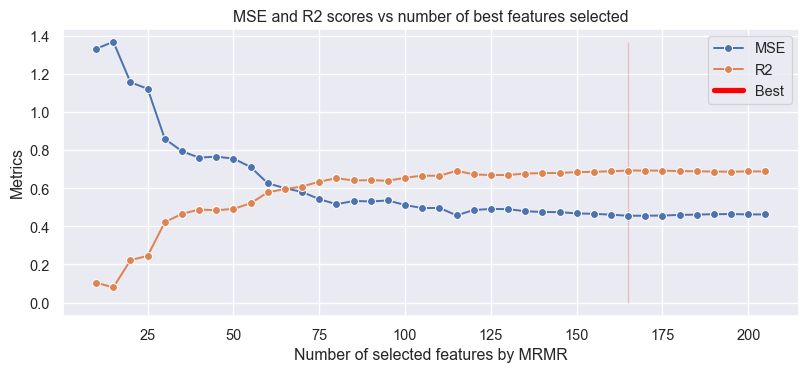

In [14]:
mse, r2 = plot_reg_fs_metrics(num_sel_feat, results, "MRMR")

In [15]:
# Take selected features by MRMR
selected_features_mrmr = features[np.argmax(r2)]

Best performance occurs when the number of selected features is **165**. Once again, model that better performs is **SVR**, with the following metrics: **R2: 0.693, MAE: 0.502, MSE: 0.456**. This means there is a **0.05** improvement in the R2 score while using **43** features less.

#### Perform Hyper parameter optimisation using randomizedSearchCV() with SVR as its the best performing baseline model

In [16]:
rnd_models_mrmr, metrics_rnd_mrmr = apply_randsearch(X_train[selected_features_mrmr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mrmr]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mrmr]
                                                        , X_val_norm[selected_features_mrmr])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
R2: 0.748425, MSE: 0.374455, MAE: 0.447647


## 2 - Improving the model: Feature Selection - Relieff 
Short description about relieff 

In [27]:
n_neighbors = 100
models_relief, results_relief, num_sel_feat_relief, features_relief = fs_relieff(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, n_neighbors)


=======================Selected features 10/207 =======================
RFR | R2: 0.531, MAE: 0.629, MSE: 0.698
DTR | R2: 0.099, MAE: 0.841, MSE: 1.342
SVR | R2: 0.508, MAE: 0.656, MSE: 0.732
MLPR | R2: 0.476, MAE: 0.655, MSE: 0.781
XGBR | R2: 0.496, MAE: 0.646, MSE: 0.750

=======================Selected features 15/207 =======================
RFR | R2: 0.573, MAE: 0.607, MSE: 0.636
DTR | R2: 0.138, MAE: 0.832, MSE: 1.283
SVR | R2: 0.562, MAE: 0.610, MSE: 0.652
MLPR | R2: 0.482, MAE: 0.656, MSE: 0.771
XGBR | R2: 0.564, MAE: 0.612, MSE: 0.649

=======================Selected features 20/207 =======================
RFR | R2: 0.591, MAE: 0.588, MSE: 0.609
DTR | R2: 0.257, MAE: 0.784, MSE: 1.105
SVR | R2: 0.595, MAE: 0.586, MSE: 0.602
MLPR | R2: 0.501, MAE: 0.642, MSE: 0.743
XGBR | R2: 0.588, MAE: 0.583, MSE: 0.614

=======================Selected features 25/207 =======================
RFR | R2: 0.594, MAE: 0.580, MSE: 0.604
DTR | R2: 0.149, MAE: 0.825, MSE: 1.267
SVR | R2: 0.609, MAE: 

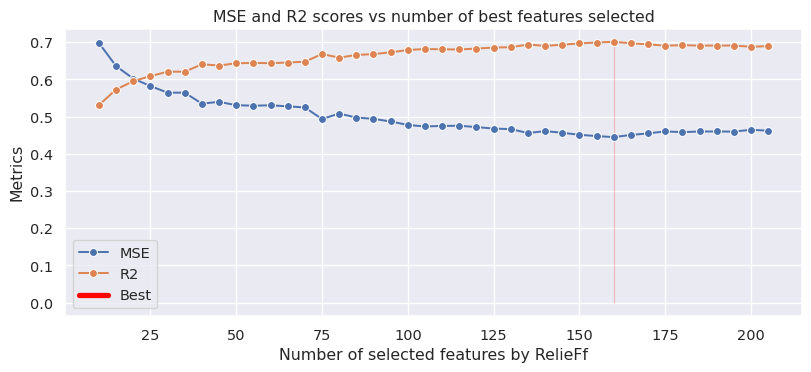

In [28]:
mse_relieff, r2_relieff = plot_reg_fs_metrics(num_sel_feat_relief, results_relief, "RelieFf")

In [29]:
# Selected features by RelieFf algorithm
selected_features_relieff = features_relief[np.argmax(r2_relieff)]

In [30]:
# Apply randsearch to the potential model candidates with the selected features
rnd_models_relieff, metrics_rnd_relieff = apply_randsearch(X_train[selected_features_relieff]
                                                        , y_train                                                       
                                                        , X_val[selected_features_relieff]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_relieff]
                                                        , X_val_norm[selected_features_relieff])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.753213, mse: 0.367328, mae: 0.446254


## 3 - Improving the model: Feature Selection - Mutual_info_regression

This method utilizes the mutual information. It calculates mutual information value for each of independent variables with respect to dependent variable, and selects the ones which has most information gain. In other words, it basically measures the dependency of features with the target value. The higher score means more dependent variables.

In [32]:
# Apply feature selection using mutual_info_regression
models_mir, results_mir, num_sel_feat_mir,features_mir = fs_score_fn(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm, False, mutual_info_regression)


=======================Selected features 10/207 =======================
RFR | R2: 0.582, MAE: 0.593, MSE: 0.622
DTR | R2: 0.274, MAE: 0.770, MSE: 1.080
SVR | R2: 0.436, MAE: 0.710, MSE: 0.839
MLPR | R2: 0.354, MAE: 0.721, MSE: 0.961
XGBR | R2: 0.560, MAE: 0.602, MSE: 0.654

=======================Selected features 15/207 =======================
RFR | R2: 0.589, MAE: 0.586, MSE: 0.612
DTR | R2: 0.228, MAE: 0.799, MSE: 1.149
SVR | R2: 0.501, MAE: 0.667, MSE: 0.742
MLPR | R2: 0.320, MAE: 0.732, MSE: 1.013
XGBR | R2: 0.569, MAE: 0.601, MSE: 0.642

=======================Selected features 20/207 =======================
RFR | R2: 0.604, MAE: 0.582, MSE: 0.589
DTR | R2: 0.265, MAE: 0.776, MSE: 1.094
SVR | R2: 0.589, MAE: 0.595, MSE: 0.612
MLPR | R2: 0.487, MAE: 0.634, MSE: 0.763
XGBR | R2: 0.629, MAE: 0.555, MSE: 0.552

=======================Selected features 25/207 =======================
RFR | R2: 0.623, MAE: 0.565, MSE: 0.561
DTR | R2: 0.301, MAE: 0.746, MSE: 1.041
SVR | R2: 0.618, MAE: 

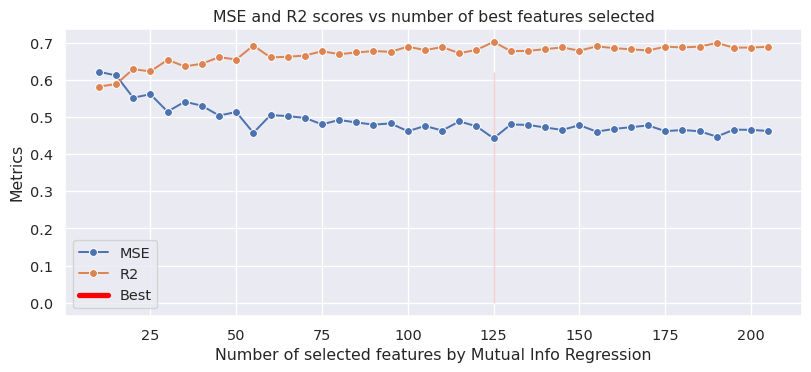

In [33]:
# Plot scores obtained
mse_mir, r2_mir = plot_reg_fs_metrics(num_sel_feat_mir, results_mir, "Mutual Info Regression")

In [34]:
# Selected features by MIR algorithm
selected_features_mir = features_mir[np.argmax(r2_mir)]

In [35]:
# Apply randsearch to the potential model candidates with the selected features
rnd_models_mir, metrics_rnd_mir = apply_randsearch(X_train[selected_features_mir]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mir]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mir]
                                                        , X_val_norm[selected_features_mir])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.736764, mse: 0.391812, mae: 0.461887


## 4 - Improving the model: Manual data cleaning

#### Pipeline
- Remove **MolLogP** and **BCUT2D** features. 
- Remove **zero variance features**. 
- Remove **high correlated** features.

#### 1 - Remove MolLogP, BCUT2D, and zero variance features. 

In [36]:
#Remove MolLogP, BCUT2D, and features with zero variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selector.fit(X_train)

# Selector.get_support() returns a [,num_descriptors] boolean mask. False represents zero variance columns.
zero_var_cols = [column for column in X_train.columns
                    if column not in X_train.columns[selector.get_support()]]

print('There are {} columns with zero variance'.format(len(zero_var_cols)))

# As BCUT features and MolLogP may have counterproductive effects, we proceed to delete them
zero_var_cols.extend([col for col in df.columns if 'BCUT2D' in col or 'MolLogP' in col])

print('Total number of features dropped:', len(zero_var_cols))

There are 10 columns with zero variance
Total number of features dropped: 19


#### 2 - Remove high correlated features

In [37]:
# We drop the features with a high correlation

corr = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than X
correlated_features = [col for col in upper.columns if any(upper[col] > 0.95)]

print('Number of correlated features deleted: {}'.format(len(correlated_features)))

Number of correlated features deleted: 29


In [38]:
# We group all the dropped features
mc_cols = list(set(X_train.columns) - set(correlated_features + zero_var_cols))

print('Total number of remaining descriptors after the data cleaning: {}'.format(len(mc_cols)))

Total number of remaining descriptors after the data cleaning: 159


### Models comparison after data cleaning

RFR | R2: 0.603, MAE: 0.580, MSE: 0.591
DTR | R2: 0.159, MAE: 0.828, MSE: 1.252
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.602, MAE: 0.556, MSE: 0.592
XGBR | R2: 0.636, MAE: 0.538, MSE: 0.542


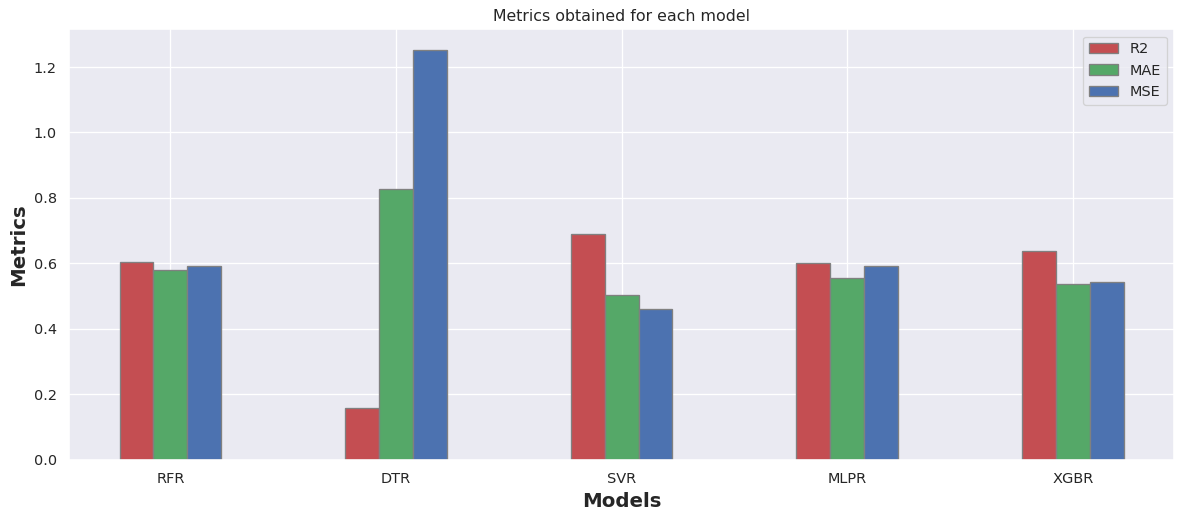

In [39]:
models, results = models_comparison(X_train[mc_cols]
                                    , y_train
                                    , X_val[mc_cols]
                                    , y_val
                                    , False
                                    , True
                                    , False
                                    , X_train_norm[mc_cols]
                                    , X_val_norm[mc_cols])

In [41]:
rnd_models_mc, metrics_rnd_mc = apply_randsearch(X_train[mc_cols]
                                                        , y_train                                                       
                                                        , X_val[mc_cols]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[mc_cols]
                                                        , X_val_norm[mc_cols])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.01, 'C': 5}
r2: 0.743075, mse: 0.382419, mae: 0.447705


## Performance against the test set 

We will now see how our best model works with the unseen test set

In [77]:
# Save the model that better performs  
joblib.dump(rnd_models_relieff[0], 'svr_relieff.pkl')

# In case loading the model 
svr_relieff = joblib.load('svr_relieff.pkl')

In [ ]:
# Predict the labels 
y_preds = svr_relieff.predict(X_test_norm[selected_features_relieff])

# Plot the metrics 
get_metrics(y_preds, y_test)